A notebook to compare results of linear models vs ensemble and boosting models on insurance data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

pd.set_option('display.max_columns', 130)

In [17]:
data = pd.read_csv('data/life_train.csv')

In [18]:
print(data.shape)
data.head(10)

(59146, 127)


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A1,26,0.230769,2,1,1,0.164179,0.636364,0.236402,0.447174,0.07000,9,1,0.00,2,0.100,1,2,3,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.565217,NaN,0.436620,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,1,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8.0
1,1,A7,26,0.000000,2,3,1,0.611940,0.836364,0.435146,0.556869,0.04800,1,3,0.00,2,0.600,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,NaN,0.715686,NaN,0.598214,3.0,217,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,1,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0
2,1,A8,26,0.076923,2,3,1,0.716418,0.727273,0.305439,0.474515,0.00000,1,3,0.03,2,NaN,2,2,3,3,1,1,1,1,1,3,1,0.002000,1,1,2,3,NaN,0.549020,NaN,0.598214,2.0,491,3,2,1,3,2,2,2,NaN,3,2,3,3,NaN,3,3,1,1,2,1,2,3,NaN,2,2,3,1,1,2,3,NaN,3,3,1,3,2,1,3,3,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
3,1,D3,26,1.000000,2,3,3,0.208955,0.836364,0.435146,0.556869,0.08100,9,1,0.00,2,0.050,1,2,3,2,1,1,1,2,1,1,3,NaN,3,2,3,3,0.434783,NaN,0.380282,NaN,0.0,342,2,1,1,3,2,2,1,NaN,3,2,3,3,NaN,1,3,1,2,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,2,A8,26,0.076923,2,1,1,0.432836,0.654545,0.215481,0.388655,0.05000,9,1,0.00,2,0.500,2,3,8,3,1,1,1,2,1,3,1,0.006333,1,3,2,3,0.594203,NaN,0.535211,NaN,17.0,112,2,1,1,3,2,2,2,NaN,3,2,3,3,47.0,1,3,1,1,2,1,2,1,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
5,1,D3,29,0.794872,2,3,1,0.253731,0.800000,0.460

In [19]:
for col in list(data):
    if data[col].isnull().sum() > 0:
        print('{0} nul in {1}'.format(data[col].isnull().sum(), col))

17 nul in Employment_Info_1
6684 nul in Employment_Info_4
10931 nul in Employment_Info_6
25046 nul in Insurance_History_5
28739 nul in Family_Hist_2
33869 nul in Family_Hist_3
19321 nul in Family_Hist_4
41431 nul in Family_Hist_5
8874 nul in Medical_History_1
58587 nul in Medical_History_10
44475 nul in Medical_History_15
55443 nul in Medical_History_24
58050 nul in Medical_History_32
14800 nul in Response


In [20]:
unlabelled_data = data[data['Response'].isnull()]
unlabelled_data.shape

(14800, 127)

In [21]:
#separating the unlabled data for now 
#data.dropna(axis=0, subset=['Response'], inplace=True)
data = data[data['Response'].notnull()] 
data.shape

(44346, 127)

In [22]:
continuous_data = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1',
                   'Employment_Info_4','Employment_Info_6', 'Insurance_History_5', 
                   'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5']

descrete_data = ['Medical_History_1', 'Medical_History_10', 'Medical_History_15',
                 'Medical_History_24', 'Medical_History_32']

In [23]:
for col in continuous_data:
    data[col].fillna(value=data[col].mean(), inplace=True)

In [24]:
for col in descrete_data:
    data[col].fillna(value=-1, inplace=True)

In [25]:
#using the quantiles did not increase the accuracy of the model
numeric = data[continuous_data].join(data[descrete_data])
print(numeric.shape)
qt = QuantileTransformer(n_quantiles=10, random_state=0)
numeric_q = pd.DataFrame(data=qt.fit_transform(numeric), index=numeric.index, columns=numeric.columns)

(44346, 18)


In [28]:
for col in descrete_data:
    print("{} has {} unique values of {}".format(col, data[col].nunique(), list(data[col].unique())))

Medical_History_1 has 167 unique values of [-1.0, 3.0, 17.0, 2.0, 0.0, 6.0, 12.0, 4.0, 26.0, 9.0, 11.0, 44.0, 1.0, 39.0, 24.0, 18.0, 15.0, 23.0, 19.0, 5.0, 30.0, 21.0, 13.0, 10.0, 8.0, 27.0, 7.0, 33.0, 14.0, 150.0, 16.0, 73.0, 78.0, 31.0, 25.0, 48.0, 28.0, 35.0, 59.0, 42.0, 112.0, 20.0, 38.0, 131.0, 60.0, 56.0, 55.0, 61.0, 34.0, 46.0, 29.0, 51.0, 32.0, 85.0, 93.0, 96.0, 36.0, 53.0, 40.0, 71.0, 114.0, 22.0, 37.0, 43.0, 64.0, 49.0, 82.0, 111.0, 84.0, 50.0, 62.0, 47.0, 86.0, 113.0, 122.0, 75.0, 58.0, 52.0, 63.0, 97.0, 57.0, 110.0, 41.0, 123.0, 147.0, 191.0, 124.0, 69.0, 102.0, 45.0, 88.0, 76.0, 153.0, 80.0, 155.0, 68.0, 74.0, 65.0, 95.0, 134.0, 187.0, 99.0, 239.0, 70.0, 107.0, 175.0, 77.0, 79.0, 83.0, 145.0, 121.0, 54.0, 67.0, 98.0, 87.0, 92.0, 89.0, 178.0, 179.0, 115.0, 94.0, 72.0, 130.0, 100.0, 229.0, 81.0, 120.0, 159.0, 106.0, 109.0, 148.0, 66.0, 103.0, 101.0, 156.0, 228.0, 126.0, 104.0, 201.0, 176.0, 108.0, 172.0, 117.0, 138.0, 91.0, 90.0, 154.0, 128.0, 146.0, 118.0, 185.0, 158.0, 240

In [29]:
#there are some questions marks '?' in the data removing them here
data.replace(' ?', np.nan, inplace=True)
data.replace('?', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data.shape

(44346, 127)

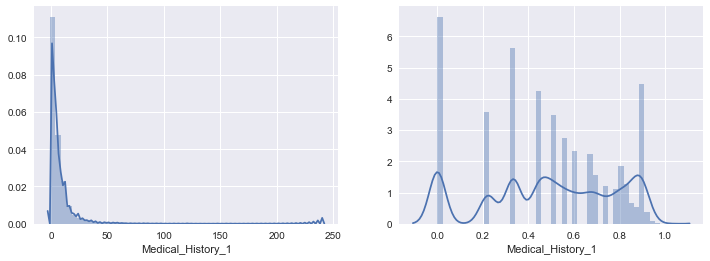

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data.Medical_History_1)
plt.subplot(1,2,2)
sns.distplot(numeric_q.Medical_History_1)

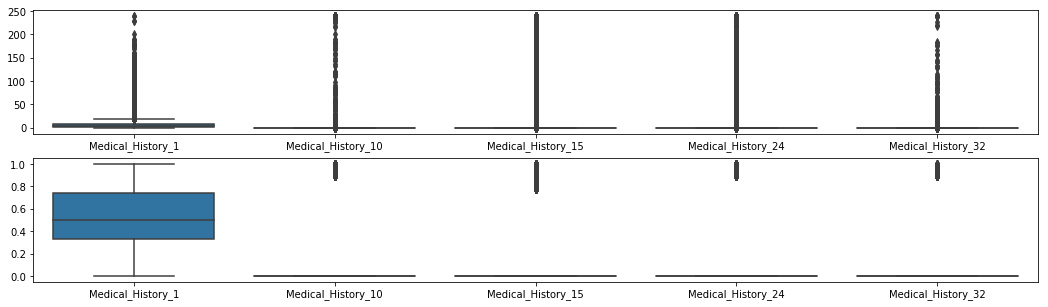

In [34]:
plt.figure(figsize=(18,5))
plt.subplot(2,1,1)
sns.boxplot(data=data[descrete_data])
plt.subplot(2,1,2)
sns.boxplot(data=numeric_q[descrete_data])

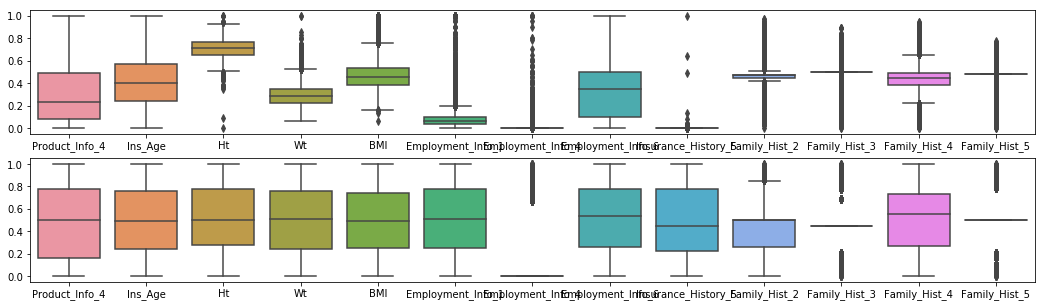

In [35]:
plt.figure(figsize=(18,5))
plt.subplot(2,1,1)
sns.boxplot(data=data[continuous_data])
plt.subplot(2,1,2)
sns.boxplot(data=numeric_q[continuous_data])

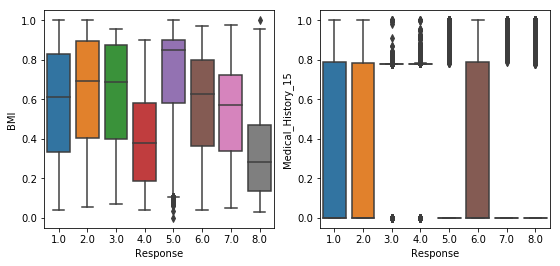

In [37]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.boxplot(y=numeric_quantiled.BMI, x=data.Response)
plt.subplot(1,3,2)
sns.boxplot(y=numeric_quantiled.Medical_History_15, x=data.Response)

In [8]:
le = LabelEncoder()
data['Product_Info_2'] = le.fit_transform(data['Product_Info_2'])

In [9]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [23]:
#trying results with quantiled results (did not result in any better score)
'''X.drop(continuous_data, axis=1, inplace=True)
X.drop(descrete_data, axis=1, inplace=True)
X = X.join(numeric_q)
X.shape'''

(44346, 126)

In [30]:
#labelEncoder gave better results so am using that
#X = pd.get_dummies(X, columns=['Product_Info_2'])
#X.shape

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [14]:
dtc.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [81]:
important_feats = dtc.best_estimator_.feature_importances_
all_feats = list(X)
feats_rating = zip(all_feats, important_feats)
importants = [(y, x) for x, y in feats_rating if y >0]
sorted(importants, reverse=True)[:10]

[(0.2627713615731756, 'BMI'),
 (0.10380010569833373, 'Medical_History_15'),
 (0.08002140537493381, 'Medical_History_4'),
 (0.07343171653125187, 'Medical_History_23'),
 (0.070575471255759761, 'Product_Info_4'),
 (0.043958063093676607, 'Ins_Age'),
 (0.035616233037718839, 'Medical_Keyword_3'),
 (0.023487696279996143, 'Family_Hist_3'),
 (0.016562870377909579, 'Employment_Info_1'),
 (0.016400901437786362, 'Wt')]

In [13]:
params = {'max_depth': [12, 14, 16], 
         'criterion': ['gini', 'entropy']}

dtc = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_test)
accuracy_score(y_test, y_dtc)

0.55425272842067286

In [45]:
lr = LogisticRegressionCV()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
print("#Mislabeled points (LR): {1} out of {0}".format(len(y_test), sum(y_lr != y_test)))
accuracy_score(y_test, y_lr)

#Mislabeled points (LR): 6041 out of 11087


0.45512762695048253

In [44]:
lda = LinearDiscriminantAnalysis() 
lda.fit(X_train, y_train)
y_lda = lda.predict(X_test)
print("#Mislabeled points (lda): {1} out of {0}".format(len(y_test), sum(y_lda != y_test)))
accuracy_score(y_test, y_lda)

#Mislabeled points (lda): 5593 out of 11087


0.49553531162622894

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=0)
y_rf = rf.fit(X_train, y_train).predict(X_test)
print("#Mislabeled points (RF): {1} out of {0}".format(len(y_test), sum(y_rf != y_test)))
accuracy_score(y_test, y_rf)

#Mislabeled points (RF): 4733 out of 11087


0.57310363488770633

In [78]:
feat_importance = rf.feature_importances_
feats = list(X)
feat_rank = zip(feat_importance, feats)
sorted(feat_rank, reverse=True)[:10]

[(0.092825967138602805, 'BMI'),
 (0.064440972797055074, 'Wt'),
 (0.042261890896023793, 'Product_Info_4'),
 (0.041222605544373549, 'Ins_Age'),
 (0.036588551418732941, 'Employment_Info_1'),
 (0.031661281599541492, 'Ht'),
 (0.030931614531595378, 'Employment_Info_6'),
 (0.030789146592275069, 'Medical_History_1'),
 (0.030554517621770281, 'Medical_History_2'),
 (0.030102119485160107, 'Medical_History_15')]

In [11]:
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')

/Users/Nargess/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=300, nthread=-1, seed=42)
gbm.fit(X_train, y_train)
y_gbm = gbm.predict(X_test)

print("#Mislabeled points (XGB) : {1} out of {0}".format(len(y_test), sum(y_gbm != y_test)))
accuracy_score(y_test, y_gbm)


#Mislabeled points (XGB) : 4496 out of 11087


0.59448002164697389

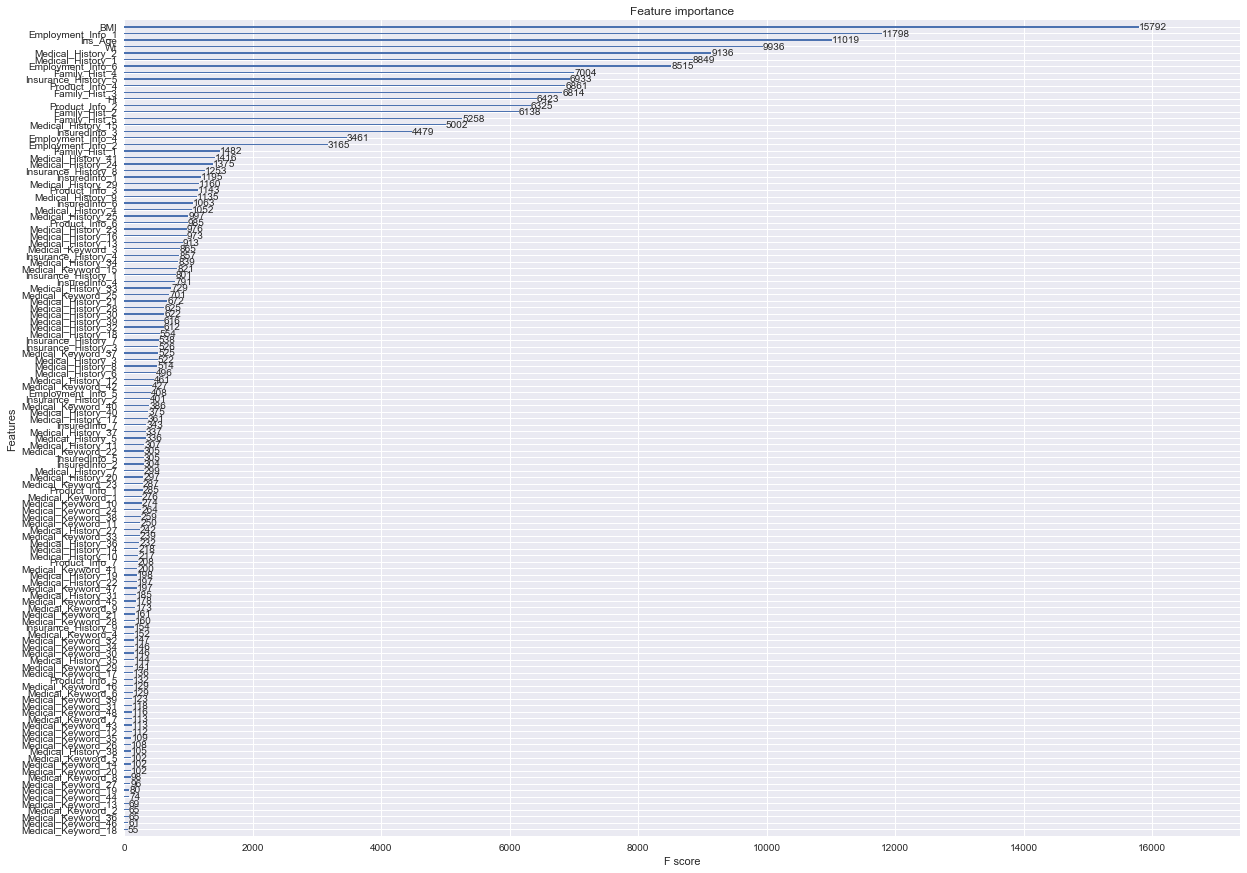

In [14]:
plt.figure(figsize=(20,15))
xgb.plot_importance(gbm, ax=plt.gca())